In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl

from packages import models
from packages import tools

from functools import reduce

from sklearn import metrics

### DONE
* Overall
    - rmse/mae
    - hourly rmses/maes
    - dotw rmses/maes

* Overall price spikes
    - rmse/mae
    - hourly rmses/maes
    - dotw rmses/maes (omitted) - mention the fact that it doesn't seem to have any discernible pattern

* COVID-related (Jan-Mar -v- Apr-Jul) (unscaled and scaled)
    - Overall RMSEs/MAEs
    - Hourly RMSEs/MAEs

* Negative price spikes -v- positive price spikes (unscaled and scaled)

* Zero prices

* Negative prices

* Variable importances

* Model-speicific fine-tuning effects --- assess the worst-performing date, the best-performing date, biggest negative spike (mid-COVID), biggest positive spike (pre-COVID)
    * Neural networks (FFNN)
        - No. of neurons 
    * SARIMAX
        - Increase no. of max iterations to monitor improvement in forecast/s
    * Random forest
        - Change max_features (and monitor performance)

## Read in forecast results

X-Model results are separate because they were run at different times.

In [2]:
# Naive
naive1d_res = pd.read_csv("Results/naive_1d_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
naive7d_res = pd.read_csv("Results/naive_7d_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
naive1y_res = pd.read_csv("Results/naive_1y_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)

# Random Forest
rf_res = pd.read_csv("Results/rf_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)

# Time Series
ar_res = pd.read_csv("Results/ar_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
arx_res = pd.read_csv("Results/arx_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
sarima_res = pd.read_csv("Results/sarima_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
sarimax_res = pd.read_csv("Results/sarimax_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)

# FFNN
sigmoid_ffnn_res = pd.read_csv("Results/sigmoid_ffnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
tanh_ffnn_res = pd.read_csv("Results/tanh_ffnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
relu_ffnn_res = pd.read_csv("Results/relu_ffnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)

# RNN
sigmoid_rnn_res = pd.read_csv("Results/sigmoid_rnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
tanh_rnn_res = pd.read_csv("Results/tanh_rnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)
relu_rnn_res = pd.read_csv("Results/relu_rnn_forecasts.csv", index_col="Unnamed: 0", parse_dates=True)

# X-Model
xm_jan = pd.read_csv("Results/xmodel_forecasts_january.csv", index_col="Unnamed: 0", parse_dates=True)
xm_feb = pd.read_csv("Results/xmodel_forecasts_february.csv", index_col="Unnamed: 0", parse_dates=True)
xm_mar = pd.read_csv("Results/xmodel_forecasts_march.csv", index_col="Unnamed: 0", parse_dates=True)
xm_apr = pd.read_csv("Results/xmodel_forecasts_april.csv", index_col="Unnamed: 0", parse_dates=True)
xm_may = pd.read_csv("Results/xmodel_forecasts_may.csv", index_col="Unnamed: 0", parse_dates=True)
xm_jun = pd.read_csv("Results/xmodel_forecasts_june.csv", index_col="Unnamed: 0", parse_dates=True)
xm_jul = pd.read_csv("Results/xmodel_forecasts_july.csv", index_col="Unnamed: 0", parse_dates=True)
xmodel_res = reduce(lambda df1, df2: df1.append(df2), [xm_jan, xm_feb, xm_mar, xm_apr, xm_may, xm_jun, xm_jul])

### Overall Performance:

In [3]:
forecasts = {
    "naive_1d": naive1d_res,
    "naive_7d": naive7d_res,
    "naive_1y": naive1y_res,
    "random_forest": rf_res,
    "AR": ar_res,
    "ARX": arx_res,
    "SARIMA": sarima_res,
    "SARIMAX": sarimax_res,
    "FFNN_sigmoid": sigmoid_ffnn_res,
    "FFNN_tanh": tanh_ffnn_res,
    "FFNN_relu": relu_ffnn_res,
    "RNN_sigmoid": sigmoid_rnn_res,
    "RNN_tanh": tanh_rnn_res,
    "RNN_relu": relu_rnn_res,
    "XModel": xmodel_res
}

rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), forecasts.values()))
maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), forecasts.values()))

Overall RMSEs and MAEs (in ascending order)

In [4]:
pd.DataFrame(dict(RMSE=rmses), index=forecasts.keys()).round(2).sort_values(by="RMSE", ascending=True)

,RMSE
RNN_sigmoid,7.91
FFNN_sigmoid,8.21
random_forest,8.31
RNN_relu,8.74
ARX,8.79
RNN_tanh,9.04
XModel,9.66
FFNN_relu,9.96
SARIMAX,10.29
FFNN_tanh,10.69


In [5]:
pd.DataFrame(dict(MAE=maes), index=forecasts.keys()).round(2).sort_values(by="MAE", ascending=True)

,MAE
RNN_sigmoid,5.67
random_forest,5.89
FFNN_sigmoid,5.89
RNN_relu,6.00
RNN_tanh,6.34
ARX,6.42
FFNN_relu,6.71
XModel,6.78
FFNN_tanh,6.93
SARIMAX,7.81


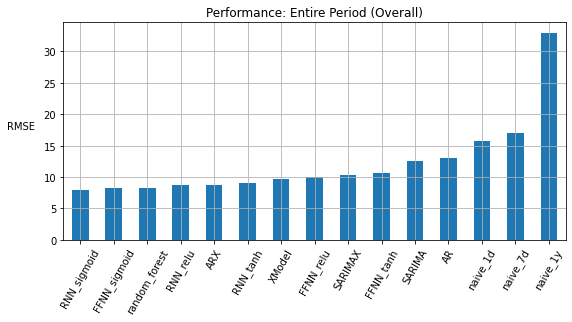

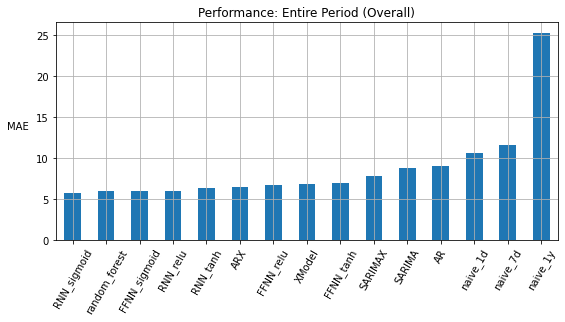

In [6]:
ax1 = pd.DataFrame(dict(RMSE=rmses), index=forecasts.keys()).sort_values(by="RMSE").plot.bar(legend=False, rot=60, figsize=(9,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=22.5)
ax1.set_title("Performance: Entire Period (Overall)")
ax1.xaxis.labelpad=200

ax2 = pd.DataFrame(dict(MAE=maes), index=forecasts.keys()).sort_values(by="MAE").plot.bar(legend=False, rot=60, figsize=(9,4), grid=True)
ax2.set_ylabel("MAE", rotation=0, labelpad=18)
ax2.set_title("Performance: Entire Period (Overall)")
plt.show()

### Some observations:
* (sigmoid) RNN and FFNN are the best, along with RFs.
* ARX did really well
* Since naive_1d performs best of all the naive forecasts, we use this as the benchmark and remove the naive_7d and naive_1y from further consideration.
* We will also do the same for the FFNNs and RNNs. We will remove the tanh and relu FFNNs and RNNs.

In [7]:
overall_forecasts = {
    "naive_1d": naive1d_res,
    "random_forest": rf_res,
    "ARX": arx_res,
    "SARIMAX": sarimax_res,
    "sigmoid_FFNN": sigmoid_ffnn_res,
    "sigmoid_RNN": sigmoid_rnn_res,
    "XModel": xmodel_res
}

rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), overall_forecasts.values()))
maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), overall_forecasts.values()))

The same plot above, but only with the best models out of each category

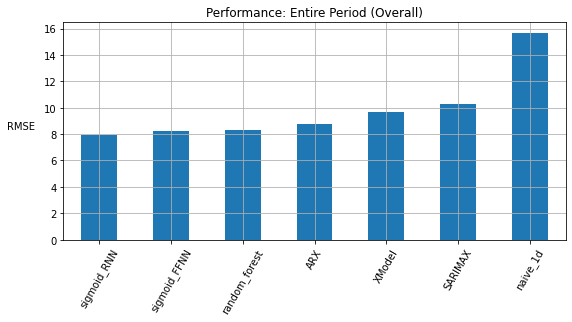

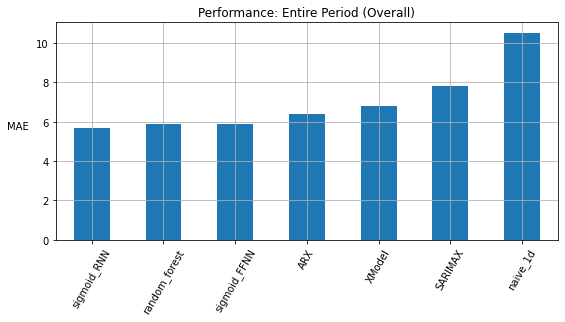

In [8]:
ax1 = pd.DataFrame(dict(RMSE=rmses), index=overall_forecasts.keys()).sort_values(by="RMSE").plot.bar(legend=False, rot=60, figsize=(9,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=22.5)
ax1.set_title("Performance: Entire Period (Overall)")
ax1.xaxis.labelpad=200

ax2 = pd.DataFrame(dict(MAE=maes), index=overall_forecasts.keys()).sort_values(by="MAE").plot.bar(legend=False, rot=60, figsize=(9,4), grid=True)
ax2.set_ylabel("MAE", rotation=0, labelpad=18)
ax2.set_title("Performance: Entire Period (Overall)")
plt.show()

Overall errors divided up across each hour of the day

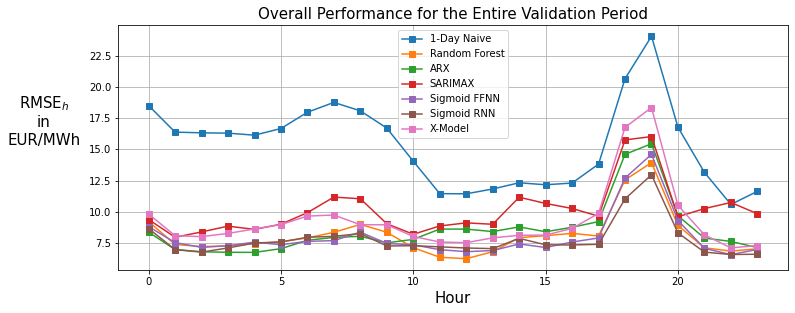

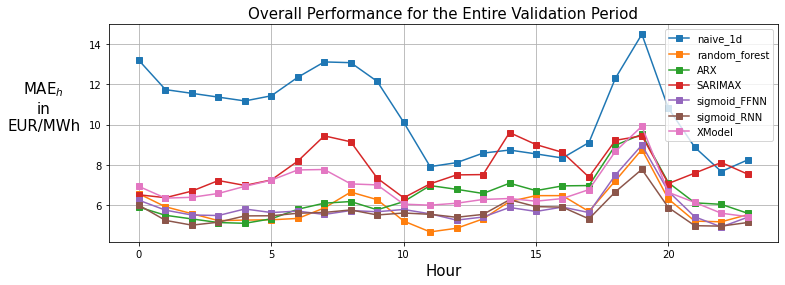

In [9]:
hourly_errors_list = list(map(lambda df: tools.get_resampled_errors(df, "hour"), overall_forecasts.values()))

hourly_rmses = pd.DataFrame(index=range(24))
hourly_maes = pd.DataFrame(index=range(24))

for column, df in zip(overall_forecasts.keys(), hourly_errors_list):
    hourly_rmses.insert(hourly_rmses.shape[1], column, df["RMSE"])
    hourly_maes.insert(hourly_maes.shape[1], column, df["MAE"])

hourly_rmses.columns = ["1-Day Naive", "Random Forest", "ARX", "SARIMAX", "Sigmoid FFNN", "Sigmoid RNN", "X-Model"]
ax = hourly_rmses.plot(figsize=(12,4.5), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("RMSE$_h$\nin\nEUR/MWh", rotation=0, fontsize=15, labelpad=45)
ax.set_title("Overall Performance for the Entire Validation Period", fontsize=15)

ax = hourly_maes.plot(figsize=(12,4), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("MAE$_h$\nin\nEUR/MWh", fontsize=15, rotation=0, labelpad=45)
ax.set_title("Overall Performance for the Entire Validation Period", fontsize=15)
plt.show()

### Some observations:
* SARIMAX and X-Model are the worst, and SARIMAX doesn't forecast well at certain points compared to other models.
* All models outperformed the 1D naive
* In RMSE plot: discernible pattern of underperformance for hours 18 and 19
* SARIMAX doesn't seem to be doing that well, along with X-Model

Overall errors divided up across each day of the week

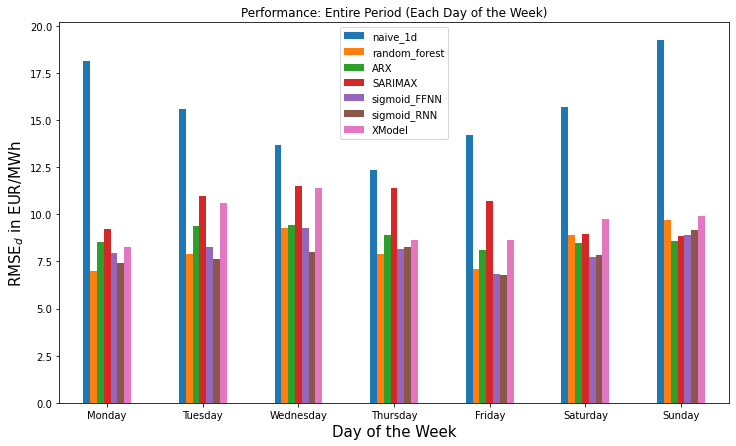

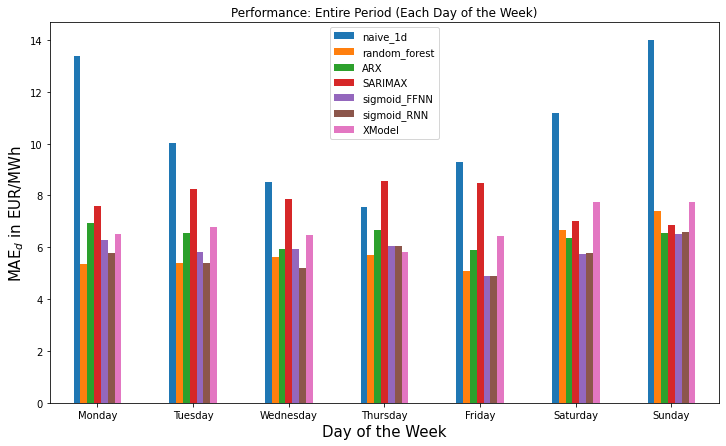

In [10]:
dotw_errors_list = list(map(lambda df: tools.get_resampled_errors(df, "dayofweek"), overall_forecasts.values()))

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dotw_rmses = pd.DataFrame(index=days_of_the_week)
dotw_maes = pd.DataFrame(index=days_of_the_week)

for column, df in zip(overall_forecasts.keys(), dotw_errors_list):
    dotw_rmses.insert(dotw_rmses.shape[1], column, df["RMSE"].values)
    dotw_maes.insert(dotw_maes.shape[1], column, df["MAE"].values)

ax1 = dotw_rmses.plot.bar(figsize=(12,7), rot=0)
ax1.set_title("Performance: Entire Period (Each Day of the Week)")
ax1.set_xlabel("Day of the Week", fontsize=15)
ax1.set_ylabel("RMSE$_d$ in EUR/MWh", fontsize=15)

ax2 = dotw_maes.plot.bar(figsize=(12,7), rot=0)
ax2.set_title("Performance: Entire Period (Each Day of the Week)")
ax2.set_xlabel("Day of the Week", fontsize=15)
ax2.set_ylabel("MAE$_d$ in EUR/MWh", fontsize=15)
plt.show()

### Some observations (nothing noteworthy):
* No significant pattern in the well-performing models.
* SARIMAX: seems to underperform a lot more in the weekdays
* X-Model: RMSE underperformance on Tuesday and Wednesday

### Price spike preformance

Get price spikes

In [11]:
# Define rolling window of interval
prices = tools.read_price_data()
rolling_prices = prices.rolling(window=24*7)

# Get rolling median
median_prices = rolling_prices.median()
median_prices.columns = ["Rolling Median Prices"]

# Quantile (of upper bound)
q = 0.9

# Get rolling upper/lower bounds
high_prices = rolling_prices.quantile(q)
high_prices.columns = ["90th percentile"]
low_prices = rolling_prices.quantile(1-q)
low_prices.columns = ["10th percentile"]

0.07143839383938394

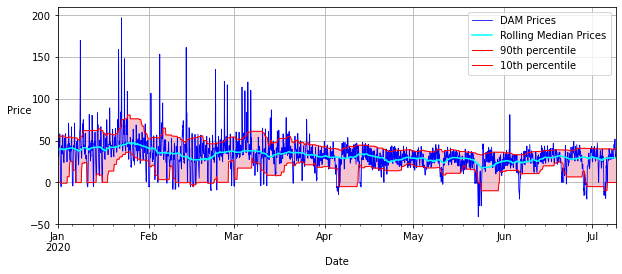

In [12]:
# Plots
relabelled_prices = prices.copy()
relabelled_prices.columns = ["DAM Prices"]
ax = relabelled_prices.plot(linewidth=0.8, color='blue', figsize=(10,4), legend=True)
median_prices.plot(ax=ax, legend=True, color='cyan')

high_prices.plot(ax=ax, color='red', legend=True, linewidth=1)
low_prices.plot(ax=ax, color='red', legend=True, linewidth=1)

# Axis limits/labels
ax.set_xlim((dt.datetime(2020,1,1), dt.datetime(2020,7,9)))
ax.set_ylim((-50,210))
ax.set_xlabel("Date")
ax.set_ylabel("Price", rotation=0, labelpad=10)
ax.grid()

# Fill in shade within 'acceptable' region
ax.fill_between(prices.index, high_prices.values.flatten(), low_prices.values.flatten(), color="crimson", alpha=0.25)

# Get prices that would be conisdered as price spikes
price_spike_index = ((prices.values > high_prices.values) | (prices.values < low_prices.values))#["DAM Prices"]

price_spikes = prices.loc[price_spike_index]
price_spikes = price_spikes.loc[price_spikes.index >= dt.datetime(2020,1,1)]

# Proportion of price data considered to be 'price spikes'
price_spikes.shape[0]/prices.shape[0]

RMSEs and MAEs for price spikes

In [13]:
overall_price_spike_forecasts = {
    "naive_1d": naive1d_res.loc[price_spikes.index].copy(),
    "random_forest": rf_res.loc[price_spikes.index].copy(),
    "ARX": arx_res.loc[price_spikes.index].copy(),
    "SARIMAX": sarimax_res.loc[price_spikes.index].copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.loc[price_spikes.index].copy(),
    "sigmoid_RNN": sigmoid_rnn_res.loc[price_spikes.index].copy(),
    "XModel": xmodel_res.loc[price_spikes.index].copy()
}

In [14]:
price_spike_rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), overall_price_spike_forecasts.values()))
price_spike_maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), overall_price_spike_forecasts.values()))

In [15]:
pd.DataFrame(dict(RMSE=price_spike_rmses), index=overall_price_spike_forecasts.keys()).round(2).sort_values(by="RMSE", ascending=True)

,RMSE
sigmoid_RNN,10.95
ARX,11.09
sigmoid_FFNN,11.72
random_forest,12.12
SARIMAX,12.16
XModel,14.76
naive_1d,22.78


In [16]:
pd.DataFrame(dict(MAE=price_spike_maes), index=overall_price_spike_forecasts.keys()).round(2).sort_values(by="MAE", ascending=True)

,MAE
ARX,7.14
sigmoid_RNN,7.37
SARIMAX,7.73
sigmoid_FFNN,8.05
random_forest,8.25
XModel,9.84
naive_1d,16.82


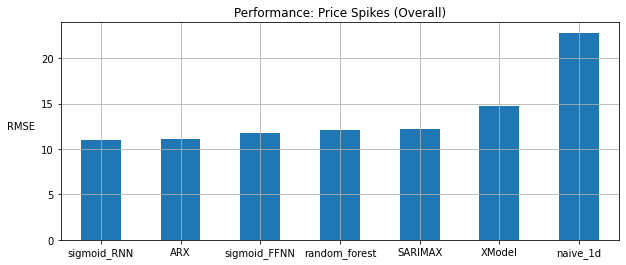

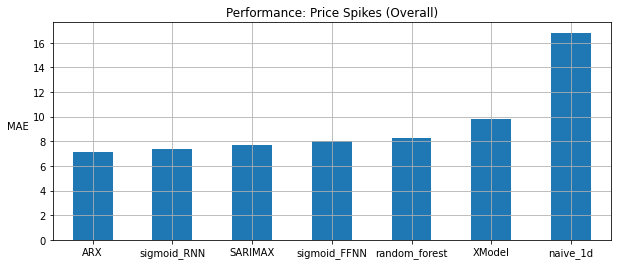

In [17]:
ax1 = pd.DataFrame(dict(RMSE=price_spike_rmses), index=overall_price_spike_forecasts.keys()).sort_values(by="RMSE").plot.bar(legend=False, rot=0, figsize=(10,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=20)
ax1.xaxis.labelpad=200
ax1.set_title("Performance: Price Spikes (Overall)")
ax2 = pd.DataFrame(dict(MAE=price_spike_maes), index=overall_price_spike_forecasts.keys()).sort_values(by="MAE").plot.bar(legend=False, rot=0, figsize=(10,4), grid=True)
ax2.set_ylabel("MAE", rotation=0, labelpad=15)
ax2.set_title("Performance: Price Spikes (Overall)")
plt.show()

### Some observations:
* ARX and sigmoid RNN are the best
* All the models except X-Model seem quite close to each other in terms of performance.

Hourly RMSEs and MAEs for price spikes

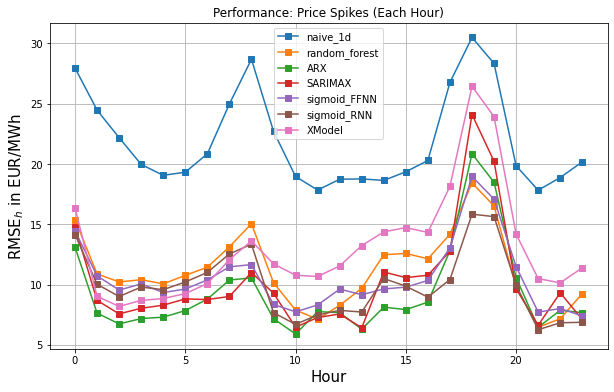

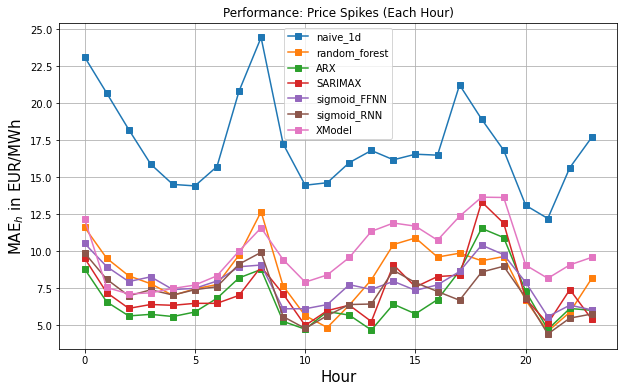

In [18]:
price_spike_forecasts_list = [res.loc[price_spikes.index] for res in overall_price_spike_forecasts.values()]
hourly_price_spike_errors = list(map(lambda df: tools.get_resampled_errors(df, "hour"), price_spike_forecasts_list))

hourly_price_spike_rmses = pd.DataFrame(index=range(24))
hourly_price_spike_maes = pd.DataFrame(index=range(24))

for column, df in zip(overall_price_spike_forecasts.keys(), hourly_price_spike_errors):
    hourly_price_spike_rmses.insert(hourly_price_spike_rmses.shape[1], column, df["RMSE"])
    hourly_price_spike_maes.insert(hourly_price_spike_maes.shape[1], column, df["MAE"])

ax = hourly_price_spike_rmses.plot(figsize=(10,6), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("RMSE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Performance: Price Spikes (Each Hour)")

ax = hourly_price_spike_maes.plot(figsize=(10,6), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("MAE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Performance: Price Spikes (Each Hour)")
plt.show()

### How other papers examine 'price spikes'
* XModel paper: Residual-based bootstrapping to assess the *likelihood* of observing a price spike
* ANN paper: A price is considered a positive (negative) price spike if it is greater (less) than some specified price level)

### COVID performance

Get pre-COVID and mid-COVID periods (Jan-Mar -v- Apr-Jul)

In [19]:
# Get pre-COVID and mid-COVID dates index
cutoff = dt.datetime(2020,4,1)
pre_covid_index = prices[(prices.index < cutoff) & (prices.index >= dt.datetime(2020,1,1))].index
mid_covid_index = prices[prices.index >= cutoff].index

In [20]:
# Get pre-COVID and mid-COVID forecasts
pre_covid_forecasts = {
    "naive_1d": naive1d_res.loc[pre_covid_index].copy(),
    "random_forest": rf_res.loc[pre_covid_index].copy(),
    "ARX": arx_res.loc[pre_covid_index].copy(),
    "SARIMAX": sarimax_res.loc[pre_covid_index].copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.loc[pre_covid_index].copy(),
    "sigmoid_RNN": sigmoid_rnn_res.loc[pre_covid_index].copy(),
    "XModel": xmodel_res.loc[pre_covid_index].copy()
}

mid_covid_forecasts = {
    "naive_1d": naive1d_res.loc[mid_covid_index].copy(),
    "random_forest": rf_res.loc[mid_covid_index].copy(),
    "ARX": arx_res.loc[mid_covid_index].copy(),
    "SARIMAX": sarimax_res.loc[mid_covid_index].copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.loc[mid_covid_index].copy(),
    "sigmoid_RNN": sigmoid_rnn_res.loc[mid_covid_index].copy(),
    "XModel": xmodel_res.loc[mid_covid_index].copy()
}

In [22]:
# Get overall errors for each period
pre_covid_rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), pre_covid_forecasts.values()))
pre_covid_maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), pre_covid_forecasts.values()))

mid_covid_rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), mid_covid_forecasts.values()))
mid_covid_maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), mid_covid_forecasts.values()))

pre-COVID -v- mid-COVID errors (sorted by pre-COVID)

In [34]:
pd.DataFrame(dict(RMSE_pre_COVID=pre_covid_rmses, RMSE_mid_COVID=mid_covid_rmses), index=pre_covid_forecasts.keys()).round(2).sort_values(by="RMSE_pre_COVID", ascending=True)

,RMSE_pre_COVID,RMSE_mid_COVID
sigmoid_RNN,9.26,6.45
random_forest,9.62,6.90
sigmoid_FFNN,9.83,6.38
ARX,10.78,6.47
XModel,11.63,7.43
SARIMAX,12.07,8.35
naive_1d,18.06,13.17


In [35]:
pd.DataFrame(dict(MAE_pre_COVID=pre_covid_maes, MAE_mid_COVID=mid_covid_maes), index=pre_covid_forecasts.keys()).round(2).sort_values(by="MAE_pre_COVID", ascending=True)

,MAE_pre_COVID,MAE_mid_COVID
sigmoid_RNN,6.76,4.68
random_forest,6.93,4.94
sigmoid_FFNN,7.13,4.77
ARX,8.03,4.95
XModel,8.09,5.58
SARIMAX,9.02,6.70
naive_1d,12.31,8.93


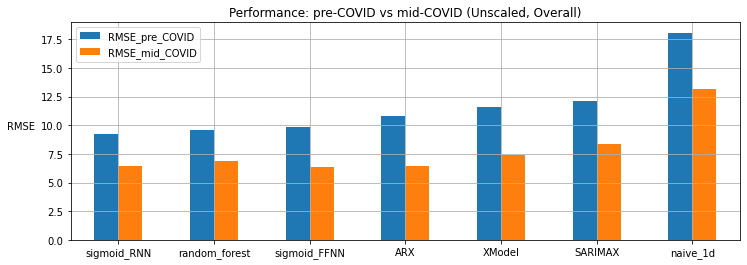

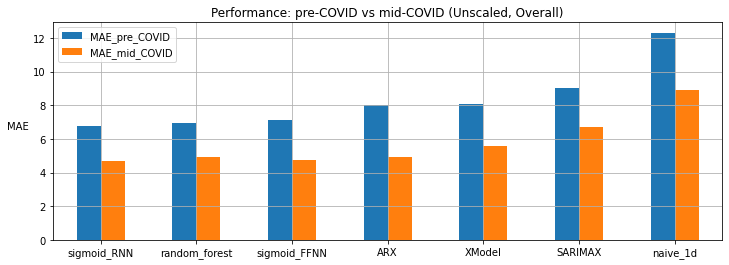

In [23]:
ax1 = pd.DataFrame(dict(RMSE_pre_COVID=pre_covid_rmses, RMSE_mid_COVID=mid_covid_rmses), index=pre_covid_forecasts.keys()).round(2).sort_values(by="RMSE_pre_COVID", ascending=True).plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=20)
ax1.xaxis.labelpad=200
ax1.set_title("Performance: pre-COVID vs mid-COVID (Unscaled, Overall)")
ax2 = pd.DataFrame(dict(MAE_pre_COVID=pre_covid_maes, MAE_mid_COVID=mid_covid_maes), index=pre_covid_forecasts.keys()).round(2).sort_values(by="MAE_pre_COVID", ascending=True).plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax2.set_ylabel("MAE", rotation=0, labelpad=15)
ax2.set_title("Performance: pre-COVID vs mid-COVID (Unscaled, Overall)")
plt.show()

### Observation:
All models outperformed in the mid-COVID compared to pre-COVID

Same as above, but scaled by mean of prices for the period

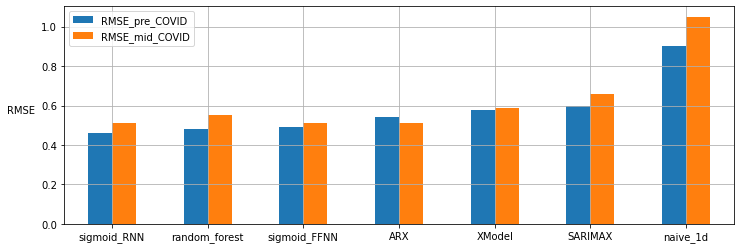

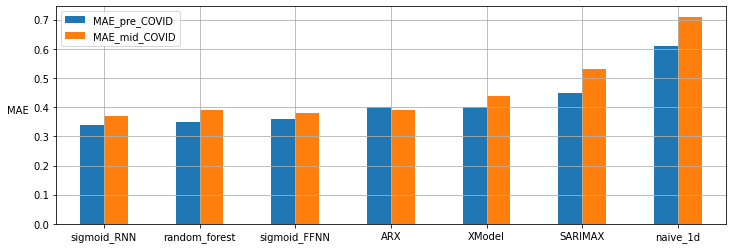

In [24]:
pre_covid_prices = prices.loc[pre_covid_index]
mid_covid_prices = prices.loc[mid_covid_index]
pre_covid_std = pre_covid_prices.std().values
mid_covid_std = mid_covid_prices.std().values

ax1 = pd.DataFrame(dict(RMSE_pre_COVID=pre_covid_rmses/pre_covid_std, RMSE_mid_COVID=mid_covid_rmses/mid_covid_std), index=pre_covid_forecasts.keys()).round(2).sort_values(by="RMSE_pre_COVID", ascending=True).plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=20)
ax1.xaxis.labelpad=200
# ax1.set_title("Performance: pre-COVID vs mid-COVID (Scaled, Overall)")
ax2 = pd.DataFrame(dict(MAE_pre_COVID=pre_covid_maes/pre_covid_std, MAE_mid_COVID=mid_covid_maes/mid_covid_std), index=pre_covid_forecasts.keys()).round(2).sort_values(by="MAE_pre_COVID", ascending=True).plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax2.set_ylabel("MAE", rotation=0, labelpad=15)
# ax2.set_title("Performance: pre-COVID vs mid-COVID (Scaled, Overall)")
plt.show()

### Observation:
* All models except ARX underperformed in mid-COVID

Hourly RMSEs and MAEs for pre-COVID -v- mid-COVID

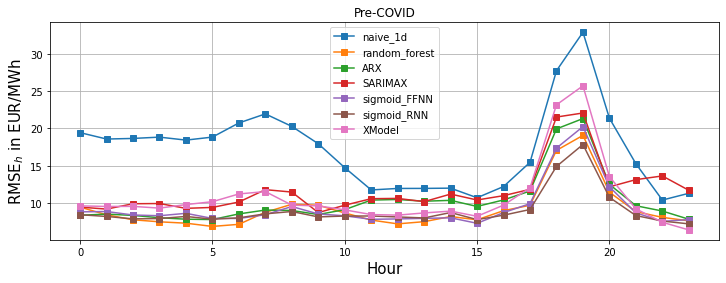

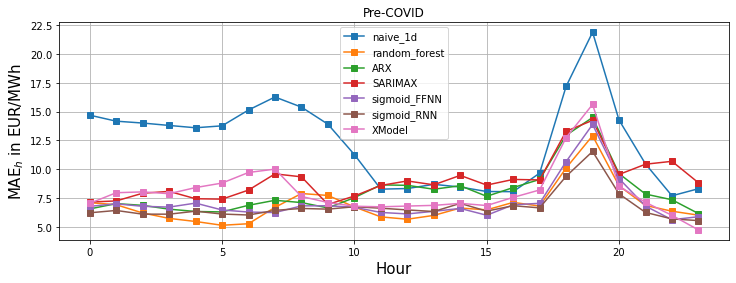

In [25]:
pre_covid_forecasts_list = [res.loc[pre_covid_index] for res in pre_covid_forecasts.values()]
hourly_pre_covid_errors = list(map(lambda df: tools.get_resampled_errors(df, "hour"), pre_covid_forecasts_list))

hourly_pre_covid_rmses = pd.DataFrame(index=range(24))
hourly_pre_covid_maes = pd.DataFrame(index=range(24))

for column, df in zip(pre_covid_forecasts.keys(), hourly_pre_covid_errors):
    hourly_pre_covid_rmses.insert(hourly_pre_covid_rmses.shape[1], column, df["RMSE"])
    hourly_pre_covid_maes.insert(hourly_pre_covid_maes.shape[1], column, df["MAE"])

ax = hourly_pre_covid_rmses.plot(figsize=(12,4), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("RMSE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Pre-COVID")
# ax.set_title("Performance: pre-COVID (Each Hour)")

ax = hourly_pre_covid_maes.plot(figsize=(12,4), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("MAE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Pre-COVID")
# ax.set_title("Performance: pre-COVID (Each Hour)")
plt.show()

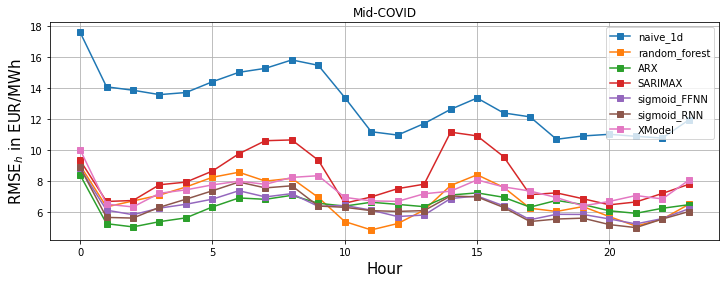

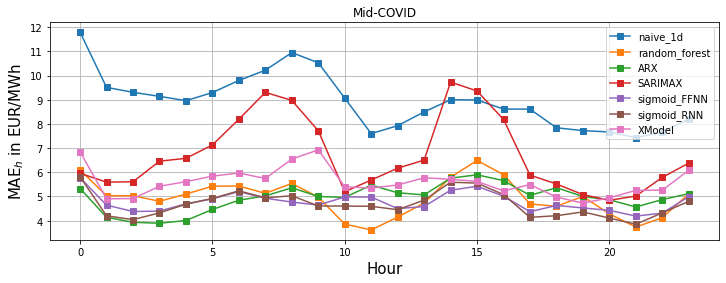

In [26]:
mid_covid_forecasts_list = [res.loc[mid_covid_index] for res in mid_covid_forecasts.values()]
hourly_mid_covid_errors = list(map(lambda df: tools.get_resampled_errors(df, "hour"), mid_covid_forecasts_list))

hourly_mid_covid_rmses = pd.DataFrame(index=range(24))
hourly_mid_covid_maes = pd.DataFrame(index=range(24))

for column, df in zip(mid_covid_forecasts.keys(), hourly_mid_covid_errors):
    hourly_mid_covid_rmses.insert(hourly_mid_covid_rmses.shape[1], column, df["RMSE"])
    hourly_mid_covid_maes.insert(hourly_mid_covid_maes.shape[1], column, df["MAE"])

ax = hourly_mid_covid_rmses.plot(figsize=(12,4), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("RMSE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Mid-COVID")
# ax.set_title("Performance: mid-COVID (Each Hour)")

ax = hourly_mid_covid_maes.plot(figsize=(12,4), linewidth=1.5, grid=True, marker="s", ms=6)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("MAE$_h$ in EUR/MWh", fontsize=15)
ax.set_title("Mid-COVID")
# ax.set_title("Performance: mid-COVID (Each Hour)")
plt.show()

### Observation:
* Spike in pre-COVID for hours 18-19 are not ind mid-COVID (probably due to the winter-summer difference and the fact that most positive price spikes in the whole period are in hours 18-19 and in the pre-COVID period).
* SARIMAX noticeable underperformance

Noticeable difference in structure of RMSE/MAE:
* Hours 18-20 are no longer 'difficult' to forecast because there are fewer price spikes in this period (see plot below of distribution of price spikes for the whole period)
    

In [27]:
period_prices = prices.loc[prices.index >= dt.datetime(2020,1,1)]

positive_price_spike_index = period_prices.loc[prices["EURPrices"] >= high_prices["90th percentile"]].index
negative_price_spike_index = period_prices.loc[prices["EURPrices"] <= low_prices["10th percentile"]].index

positive_price_spikes = prices.loc[positive_price_spike_index]
negative_price_spikes = prices.loc[negative_price_spike_index]

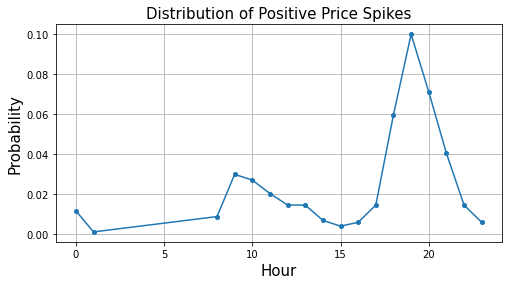

In [28]:
positive_price_spikes_per_hour = positive_price_spikes.groupby(positive_price_spikes.index.hour)
ax=(positive_price_spikes_per_hour.count() / price_spikes.shape[0]).plot(marker='o', ms=4, legend=False, figsize=(8,4))
# ax.set_title("Distribution of Positive Price Spike Hours")
ax.set_ylabel("Probability", fontsize=15)
ax.set_xlabel("Hour", fontsize=15)
ax.set_title("Distribution of Positive Price Spikes", fontsize=15)
ax.grid()
plt.show()

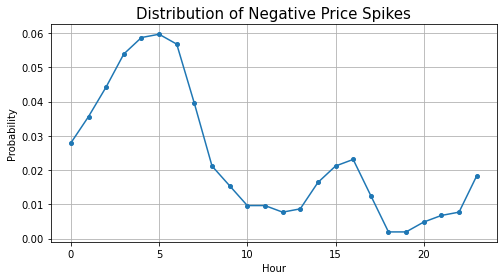

In [29]:
negative_price_spikes_per_hour = negative_price_spikes.groupby(negative_price_spikes.index.hour)
ax=(negative_price_spikes_per_hour.count() / price_spikes.shape[0]).plot(marker='o', ms=4, legend=False, figsize=(8,4))
# ax.set_title("Distribution of Negative Price Spike Hours")
ax.set_ylabel("Probability")
ax.set_xlabel("Hour")
ax.set_title("Distribution of Negative Price Spikes", fontsize=15)
ax.grid()
plt.show()

### Positive price spikes -v- negative price spikes

In [30]:
# Get positive price spike forecasts
positive_price_spike_forecasts = {
    "naive_1d": naive1d_res.loc[positive_price_spike_index].copy(),
    "random_forest": rf_res.loc[positive_price_spike_index].copy(),
    "ARX": arx_res.loc[positive_price_spike_index].copy(),
    "SARIMAX": sarimax_res.loc[positive_price_spike_index].copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.loc[positive_price_spike_index].copy(),
    "sigmoid_RNN": sigmoid_rnn_res.loc[positive_price_spike_index].copy(),
    "XModel": xmodel_res.loc[positive_price_spike_index].copy()
}

# Get negative price spike forecasts
negative_price_spike_forecasts = {
    "naive_1d": naive1d_res.loc[negative_price_spike_index].copy(),
    "random_forest": rf_res.loc[negative_price_spike_index].copy(),
    "ARX": arx_res.loc[negative_price_spike_index].copy(),
    "SARIMAX": sarimax_res.loc[negative_price_spike_index].copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.loc[negative_price_spike_index].copy(),
    "sigmoid_RNN": sigmoid_rnn_res.loc[negative_price_spike_index].copy(),
    "XModel": xmodel_res.loc[negative_price_spike_index].copy()
}

In [32]:
# Get overall errors for each set
positive_price_spike_rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), positive_price_spike_forecasts.values()))
positive_price_spike_maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), positive_price_spike_forecasts.values()))

negative_price_spike_rmses = list(map(lambda df: metrics.mean_squared_error(df["Forecast"], df["Original"], squared=False), negative_price_spike_forecasts.values()))
negative_price_spike_maes = list(map(lambda df: metrics.mean_absolute_error(df["Forecast"], df["Original"]), negative_price_spike_forecasts.values()))

Positive price spikes performance -v- Negative price spikes performance

In [33]:
pd.DataFrame(dict(RMSE_positive_spikes=positive_price_spike_rmses, RMSE_negative_spikes=negative_price_spike_rmses), index=positive_price_spike_forecasts.keys()).round(2).sort_values(by="RMSE_positive_spikes", ascending=True)

,RMSE_positive_spikes,RMSE_negative_spikes
sigmoid_RNN,12.03,9.90
random_forest,12.96,11.34
sigmoid_FFNN,13.66,9.80
ARX,13.92,8.01
SARIMAX,15.49,8.50
XModel,18.65,10.61
naive_1d,23.74,21.80


In [34]:
pd.DataFrame(dict(MAE_positive_spikes=positive_price_spike_maes, MAE_negative_spikes=negative_price_spike_maes), index=positive_price_spike_forecasts.keys()).round(2).sort_values(by="MAE_positive_spikes", ascending=True)

,MAE_positive_spikes,MAE_negative_spikes
sigmoid_RNN,7.15,7.47
random_forest,7.46,8.88
ARX,8.10,6.29
sigmoid_FFNN,8.22,7.85
SARIMAX,9.23,6.51
XModel,11.22,8.75
naive_1d,15.33,17.84


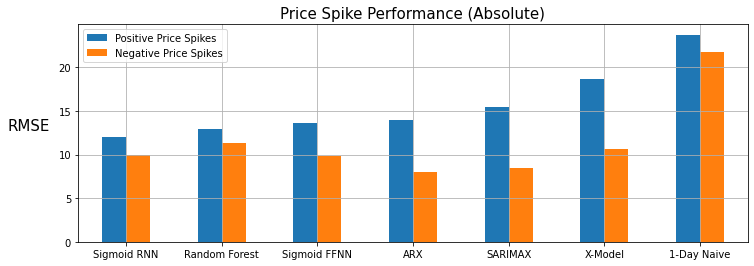

In [35]:
data_dict = {
    "Positive Price Spikes": positive_price_spike_rmses,
    "Negative Price Spikes": negative_price_spike_rmses
}
data = pd.DataFrame(data_dict, index=pre_covid_forecasts.keys()).round(2).sort_values(by="Positive Price Spikes", ascending=True)
data.index = ["Sigmoid RNN", "Random Forest", "Sigmoid FFNN", "ARX", "SARIMAX", "X-Model", "1-Day Naive"]
ax1 = data.plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=30, fontsize=15)
ax1.set_title("Price Spike Performance (Absolute)", fontsize=15)
# ax1.xaxis.labelpad=100
plt.show()

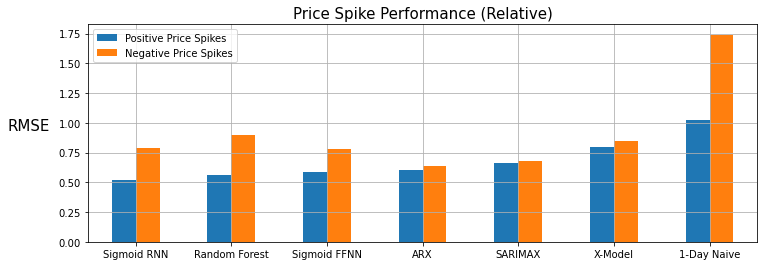

In [36]:
positive_spikes_std = positive_price_spikes.std().values
negative_spikes_std = negative_price_spikes.std().values
scaled_data_dict = {
    "Positive Price Spikes": positive_price_spike_rmses/positive_spikes_std,
    "Negative Price Spikes": negative_price_spike_rmses/negative_spikes_std
}

data = pd.DataFrame(scaled_data_dict, index=pre_covid_forecasts.keys()).round(2).sort_values(by="Positive Price Spikes", ascending=True)
data.index = ["Sigmoid RNN", "Random Forest", "Sigmoid FFNN", "ARX", "SARIMAX", "X-Model", "1-Day Naive"]
ax1 = data.plot.bar(legend=True, rot=0, figsize=(12,4), grid=True)
ax1.set_ylabel("RMSE", rotation=0, labelpad=30, fontsize=15)
ax1.set_title("Price Spike Performance (Relative)", fontsize=15)
# ax1.xaxis.labelpad=200
plt.show()

### Some observations:
RMSE: All models perform better with negative price spikes than with positive price spikes, but this is to be expected given that the magnitude/volatility of the positive price spikes is larger than that of the negative price spikes.

### Variable Importance

As the RF implementation allows us to get a summary of variable importances (on the training set), we stored these variable importances for each given date in the walk-forward validation period.

*Interpretation:* SKLearn normalizes the average reduction in RSS of the predictors to be in the range [0,1]
On average, for each day-ahead forecast, $\text{VI}_p\%$ of the variability in the training data can be explained by the predictor $p$ above.

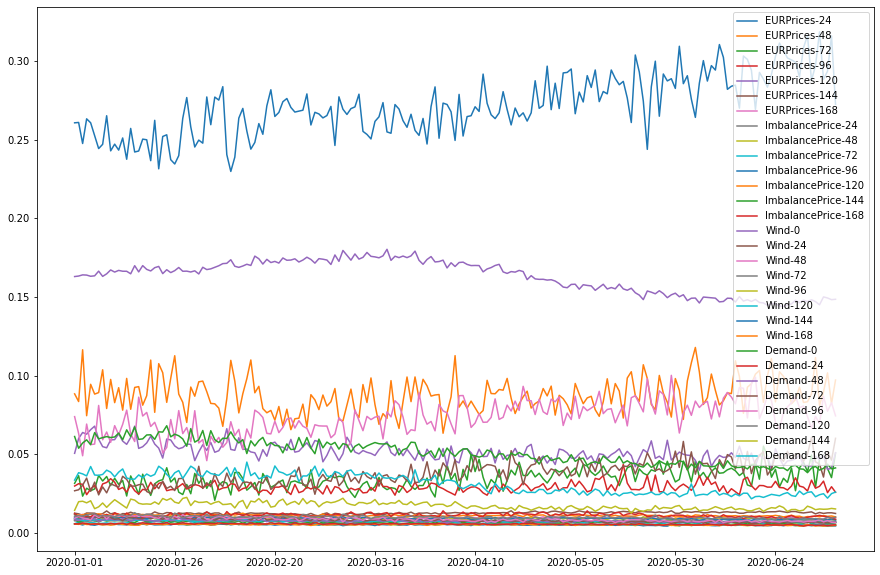

In [38]:
# Variable importances over each date
rf_vis = pd.read_csv("Results/rf_vi.csv", index_col="Unnamed: 0")
rf_vis.T.plot(figsize=(15,10))
plt.show()

The variable importance implementation under sklearn.RandomForestRegressor normalises the VI values, so that (for each given forecast date), the sum of all variable importances is one, as can be seen below.

In [44]:
rf_vis.sum()

2020-01-01    1.0
2020-01-02    1.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    1.0
             ... 
2020-07-05    1.0
2020-07-06    1.0
2020-07-07    1.0
2020-07-08    1.0
2020-07-09    1.0
Length: 191, dtype: float64

Calculating the mean variable importance of each feature in the period:

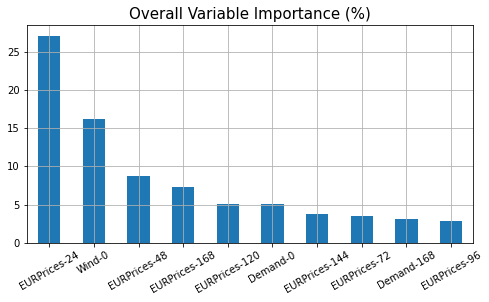

,VI$_p$
EURPrices-24,27.2
Wind-0,16.3
EURPrices-48,8.8
EURPrices-168,7.3
EURPrices-120,5.1
Demand-0,5.1
EURPrices-144,3.8
EURPrices-72,3.5
Demand-168,3.1
EURPrices-96,2.9


In [54]:
mean_vis = rf_vis.mean(axis=1).sort_values(ascending=False)
top_vis = 100*mean_vis[:10]
ax = top_vis.plot.bar(figsize=(8,4), rot=30)
# ax.set_title("Variable Importances")
ax.set_title("Overall Variable Importance (%)", fontsize=15)
ax.grid()
plt.show()
top_vis = top_vis.to_frame()
top_vis.columns = ["VI$_p$"]
top_vis.round(1)

Variable importances (in the top 10):

In [67]:
features = ["EURPrices", "ImbalancePrice", "Wind", "Demand"]
for feature in features:
    feature_vis = pd.Series(top_vis.values.flatten(), index=top_vis.index).filter(regex=feature)
    total_vi = feature_vis.sum()
    print(f"{feature}:", np.round(total_vi,1))

EURPrices: 58.6
ImbalancePrice: 0.0
Wind: 16.3
Demand: 8.2


Variable importances (overall):

In [47]:
features = ["EURPrices", "ImbalancePrice", "Wind", "Demand"]
for feature in features:
    feature_vis = mean_vis.filter(regex=feature)*100
    total_vi = feature_vis.sum()
    print(f"{feature}:", np.round(total_vi,1))

EURPrices: 58.6
ImbalancePrice: 4.1
Wind: 22.9
Demand: 14.5


# Monitoring performance with respect to some hyperparameters

To reduce computation time, we will reduce the number of walk-forward validation dates to 4:
    * Greatest (magnitude) positive spike
    * Greatest (magnitude) negative spike
    * Most common day of best performance
    * Most common day of worst performance

Get biggest positive and negative price spikes (in terms of price level)

In [68]:
positive_price_spikes.loc[(positive_price_spikes == positive_price_spikes.max().values)["EURPrices"]]

,EURPrices
DeliveryPeriod,
2020-01-22 18:00:00,196.79


In [69]:
negative_price_spikes.loc[(negative_price_spikes == negative_price_spikes.min().values)["EURPrices"]]

,EURPrices
DeliveryPeriod,
2020-05-23 06:00:00,-41.09


In [70]:
price_spike_dates = [dt.datetime(2020,1,22), dt.datetime(2020,5,23)]

Get best and worst days of performance overall

overall_forecasts = {
    "naive_1d": naive1d_res.copy(),
    "random_forest": rf_res.copy(),
    "ARX": arx_res.copy(),
    "SARIMAX": sarimax_res.copy(),
    "sigmoid_FFNN": sigmoid_ffnn_res.copy(),
    "sigmoid_RNN": sigmoid_rnn_res.copy(),
    "tanh_RNN": tanh_rnn_res.copy(),
    "XModel": xmodel_res.copy()
}

In [77]:
date_errors = list(map(lambda df: tools.get_resampled_errors(df, "date")[["RMSE"]], overall_forecasts.values()))
best_dates = [df.loc[df.values == df.min().values].index for df in date_errors]
worst_dates = [df.loc[df.values == df.max().values].index for df in date_errors]

In [88]:
best_dates

[Index([2020-06-26], dtype='object'),
 Index([2020-06-26], dtype='object'),
 Index([2020-05-15], dtype='object'),
 Index([2020-03-29], dtype='object'),
 Index([2020-05-15], dtype='object'),
 Index([2020-05-15], dtype='object'),
 Index([2020-06-25], dtype='object'),
 Index([2020-05-14], dtype='object')]

In [89]:
worst_dates

[Index([2020-01-08], dtype='object'),
 Index([2020-01-08], dtype='object'),
 Index([2020-01-22], dtype='object'),
 Index([2020-01-22], dtype='object'),
 Index([2020-01-22], dtype='object'),
 Index([2020-05-24], dtype='object'),
 Index([2020-03-13], dtype='object'),
 Index([2020-01-22], dtype='object')]

Will choose 2020-05-15 (best) and 2020-01-08 (worst)

In [90]:
dates_to_test = [dt.datetime(2020,5,15), dt.datetime(2020,1,8)] + price_spike_dates

In [91]:
dates_to_test

[datetime.datetime(2020, 5, 15, 0, 0),
 datetime.datetime(2020, 1, 8, 0, 0),
 datetime.datetime(2020, 1, 22, 0, 0),
 datetime.datetime(2020, 5, 23, 0, 0)]

In [92]:
# Read planned/forecast data
wind_forecast = tools.read_forecast_data("Wind")
demand_forecast = tools.read_forecast_data("Demand")
planned = pd.concat([wind_forecast, demand_forecast], axis=1)

data = {
    "prices": tools.read_price_data(),
    "bm_prices": tools.read_bm_price_data(),
    "planned": planned
}

FFNN - Number of neurons per layer

In [ ]:
importlib.reload(tools)
importlib.reload(models)

lag_params = {
    "price_lags": [24,48,72,96,120,144,168],
    "bm_price_lags": [24,48,72,96,168],
    "planned_lags": [0,24,48,72,96,168]
}

model_params = {
    "init_params": {
        "num_of_nodes": list(range(1,101)),
        "input_cols": len(lag_params["price_lags"])+len(lag_params["bm_price_lags"])+2*len(lag_params["planned_lags"]),
        "act_fn": "sigmoid",
    },
    "train_params": {
        "validation_split": 0,
        "verbose": 0
    },
    "other_params": {
        "init_epochs": 2200,
        "subseq_epochs": 500,
        "GPU": True
    }
}

ffnn_hyperparameter_errors = tools.walk_forward_loop(models.ffnn, dates_to_test, model_params, lag_params, "num_of_nodes", **data)

In [ ]:
# ffnn_hyperparameter_errors.to_csv("Results/ffnn_hyperparameter_errors.csv")

SARIMAX - maxiter

In [ ]:
importlib.reload(tools)
importlib.reload(models)

model_params = {
    "exog": True,
    "trend": "n",
    "order": (4,1,4),
    "seasonal_order": (0,1,1,24),
    "method": "lbfgs",
    "maxiter": np.arange(5,300,5).tolist(),
    "disp": False
}

lag_params = {
    "bm_price_lags": [24,48,72,96,120,144,168],
    "planned_lags": [0,24,48,72,96,120,144,168]
}

sarimax_hyperparameter_errors = tools.walk_forward_loop(models.SARIMAX, dates_to_test, model_params, lag_params, "maxiter", **data)

In [ ]:
# sarimax_hyperparameter_errors.to_csv("Results/sarimax_hyperparameter_errors.csv")

Random Forest - max_features

In [ ]:
importlib.reload(tools)
importlib.reload(models)

model_params = {
    "n_estimators": 100,
    "max_depth": 26,
    "max_features": list(range(1, 31)),
    "n_jobs": -1
}

lag_params = {
    "price_lags": [24,48,72,96,120,144,168],
    "bm_price_lags": [24,48,72,96,120,144,168],
    "planned_lags": [0,24,48,72,96,120,144,168]
}

rf_hyperparameter_errors = tools.walk_forward_loop(models.random_forest, dates_to_test, model_params, lag_params, "max_features", **data)

In [ ]:
# sarimax_hyperparameter_errors.to_csv("Results/rf_hyperparameter_errors.csv")

In [ ]:
sigmoid_ffnn1 = sigmoid_ffnn_res["2020-05-15"]
sigmoid_ffnn2 = sigmoid_ffnn_res["2020-01-08"]
sigmoid_ffnn3 = sigmoid_ffnn_res["2020-01-22"]
sigmoid_ffnn4 = sigmoid_ffnn_res["2020-05-23"]
sigmoid_ffnn_spec_dates = reduce(lambda df1, df2: df1.append(df2), [sigmoid_ffnn1, sigmoid_ffnn2, sigmoid_ffnn3, sigmoid_ffnn4])

sigmoid_ffnn_rmse = metrics.mean_squared_error(sigmoid_ffnn_spec_dates["Original"], sigmoid_ffnn_spec_dates["Forecast"], squared=False).round(2)
sigmoid_ffnn_mae = metrics.mean_absolute_error(sigmoid_ffnn_spec_dates["Original"], sigmoid_ffnn_spec_dates["Forecast"]).round(2)

In [ ]:
ax = ffnn_hyperparameter_errors["RMSE"].plot(figsize=(10,4), marker='o', ms=3.25)
ax.grid()
ax.hlines(y=sigmoid_ffnn_rmse, xmin=-10, xmax=120,  label="original model RMSE" , linewidth=1, linestyle="--", color='red')
# ax.hlines(y=sigmoid_ffnn_mae, xmin=-10, xmax=120, label="original model MAE", linewidth=1, linestyle="--", color='green')
ax.set_xlim((0,100))
ax.set_ylim(15,45)
ax.set_ylabel("RMSE", rotation=0, labelpad=22.5)
ax.legend()
plt.show()

In [ ]:
sarimax1 = sarimax_res["2020-05-15"]
sarimax2 = sarimax_res["2020-01-08"]
sarimax3 = sarimax_res["2020-01-22"]
sarimax4 = sarimax_res["2020-05-23"]
sarimax_spec_dates = reduce(lambda df1, df2: df1.append(df2), [sarimax1, sarimax2, sarimax3, sarimax4])

sarimax_rmse = metrics.mean_squared_error(sarimax_spec_dates["Original"], sarimax_spec_dates["Forecast"], squared=False).round(2)
sarimax_mae = metrics.mean_absolute_error(sarimax_spec_dates["Original"], sarimax_spec_dates["Forecast"]).round(2)

In [ ]:
ax = sarimax_hyperparameter_errors["RMSE"].plot(figsize=(10,4), marker='o', ms=3.24)
ax.grid()
ax.hlines(y=sarimax_rmse, xmin=-10, xmax=320,  label="original model RMSE" , linewidth=1, linestyle="--", color='red')
# ax.hlines(y=sarimax_mae, xmin=-10, xmax=320, label="original model MAE", linewidth=1, linestyle="--", color='green')
ax.legend()
ax.set_ylabel("RMSE", rotation=0, labelpad=22.5)
ax.set_xlim((0,300))
ax.set_ylim((19.4,20.6))
plt.show()

In [ ]:
rf1 = rf_res["2020-05-15"]
rf2 = rf_res["2020-01-08"]
rf3 = rf_res["2020-01-22"]
rf4 = rf_res["2020-05-23"]
rf_spec_dates = reduce(lambda df1, df2: df1.append(df2), [rf1, rf2, rf3, rf4])

rf_rmse = metrics.mean_squared_error(rf_spec_dates["Original"], rf_spec_dates["Forecast"], squared=False).round(2)
rf_mae = metrics.mean_absolute_error(rf_spec_dates["Original"], rf_spec_dates["Forecast"]).round(2)

In [ ]:
ax = rf_hyperparameter_errors["RMSE"].plot(figsize=(10,4), marker='o', ms=3.25)
ax.grid()
ax.hlines(y=rf_rmse, xmin=-10, xmax=120,  label="original model RMSE" , linewidth=1, linestyle="--", color='red')
# ax.hlines(y=rf_mae, xmin=-10, xmax=120, label="original model MAE", linewidth=1, linestyle="--", color='green')
ax.legend()
ax.set_ylabel("RMSE", rotation=0, labelpad=22.5)
ax.set_xlim((0,30))
ax.set_ylim(17,26)
plt.show()